# SC04 Group 08 DDW 2D Task 2

## Problem Statement:

### How might we predict whether an individual in South America will be admitted to the ICU or not, due to contracting COVID-19, based on a variety of medical records?

### Premise of dataset

The dataset that we have obtained is from Hospital Sírio-Libanês, São Paulo and Brasilia. It contains anonymised medical record data for individuals, with a 'ICU' column that contains '1' if that individual has been admitted to the ICU due to COVID'19, and '0' otherwise. The other columns are various medical tests that the individual has undergone prior to being admitted to the ICU.


We aim to predict an individual's admittance into ICU after he/she has contracted COVID-19 using a Logistic Regression model. 


Before training the model, we have undergone a series of pre-processing steps to transform the dataset to be suitably fitted into the model. After that, we have made some iterations to simplify the model while improving our evaluation metrics. 


### Assumption:
The genetic makeup of Brazilians are somewhat similar to the general South American population; hence our model will be able to accurately predict the ICU admittance of any individual of South American descent.

### Import statements for various python libraries

In [239]:
import pandas as pd 
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import itertools

# Data Pre-processing

### Importing the dataset from .csv format to a pandas dataframe and displaying it. 

In [240]:
df_main = pd.read_csv('Kaggle_Sirio_Libanes_ICU_Prediction.csv')

df_main

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1921,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
1922,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
1923,384,0,50th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0


## Creating a list of all the column names in the main dataframe

In [241]:
ls_main_colnames = df_main.columns.tolist()

## Preliminary filtering: Removing columns based on preliminary filtering

1. The "patient_visit_identifier" is simply a numerical value given to each patient, to mask their identity. This does not provide any significance to the machine learning model.


2. For the 42 different medical variables provided, each of them are broken down into "..._MEAN", "..._MEDIAN", "..._MIN", 
   "..._MAX", "..._DIFF" categories. After arbitrarily choosing MEAN and DIFF to be included in the dataframe and removing the    rest, we found that many of the DIFF columns were filled with the same values. As such, we removed the DIFF columns as well,
   as columns of constant values will not be useful inputs for our machine learning model.
   


In [242]:
## Initial no. of cols: 231
## Number of cols that should be left: 44 including target

ls_cols_we_need = []

## Code to remove the 187 cols:

## Creating a list for the 42 (times 4) medical cols to be removed:
ls_medical_colnames = ls_main_colnames[13:231]
ls_medical_colnames_5 = ls_medical_colnames[:180]
ls_medical_colnames_6 = ls_medical_colnames[180:-2]

## For each val in ls_medical_colnames_5, we want to keep 2nd name, which is "..._MEAN".
## Appending the relevant colnames into ls_medical_colnames_2
ls_medical_colnames_2 = list()
for item in ls_medical_colnames:
    if 'MEAN' in item:
        ls_medical_colnames_2.append(item)
    
for item in ls_medical_colnames_2:
    if 'REL' in item:
        ls_medical_colnames_2.remove(item)
    
ls_medical_colnames_2 = ls_medical_colnames_2[:-3] ## Removing last 3 items from ls_medical_colnames_2 due to their irrelevance

## End of cleaning medical columns, have 39 columns now. need to add the personal columns now. 

five_cols = ['AGE_ABOVE65',  'AGE_PERCENTIL', 'GENDER', 'WINDOW', 'ICU']

ls_cols_we_need = five_cols[:-1] + ls_medical_colnames_2 + five_cols[-1:]

## Dataframe with appropriate columns

In [243]:
## Create a dataframe with the columns from ls_cols_we_need 

df_filtered = df_main.loc[:, ls_cols_we_need]

df_filtered ## Main dataframe to be used from now on

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,...,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,ICU
0,1,60th,0,0-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.086420,-0.230769,-0.283019,0
1,1,60th,0,2-4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,-0.230769,-0.132075,0
2,1,60th,0,4-6,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,...,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,NaN,NaN,NaN,0
3,1,60th,0,6-12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,60th,0,ABOVE_12,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,...,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,50th,1,0-2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012346,-0.292308,0.056604,0
1921,0,50th,1,2-4,0.605263,-1.000000,-0.717277,-0.317073,-0.170732,-0.982208,...,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.086420,-0.384615,-0.113208,0
1922,0,50th,1,4-6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.086420,-0.230769,-0.169811,0
1923,0,50th,1,6-12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.209877,-0.384615,-0.188679,0


## Changing datatypes in certain columns into usable datatype

1. WINDOW: The original values in this column are string values. They signified the range in which each patient was admitted into the hospital. The values '0-2', '2-4', '4-6', '6-12' and 'ABOVE_12' have been mapped to 1, 3, 8 and 13 respectively, for the model to be trained accurately. 


2. AGE_PERCENTIL: The original values in this column are also string values. They signified the percentile of each patient's age, in intervals of 10% to prevent revealing too much of the patient's identities. These values have been converted into float values using the .replace() method. 

In [244]:
## Changing window values into integers, 0-2 --> 1, 2-4 --> 3, 6-12 --> 8, ABOVE_12 --> 13

df_new = df_filtered.replace({'0-2':1, '2-4':3, '4-6':5, '6-12':8, 'ABOVE_12':13})

## removing "th" from each value and converting into float

df_new2 = df_new.replace({'10th':0.1, '20th':0.2, '30th':0.3, '40th':0.4, '50th':0.5, '60th':0.6, '70th':0.7, '80th':0.8, '90th':0.9, 'Above 90th':0.95})

df_new2

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,...,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,ICU
0,1,0.6,0,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.086420,-0.230769,-0.283019,0
1,1,0.6,0,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,-0.230769,-0.132075,0
2,1,0.6,0,5,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,...,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,NaN,NaN,NaN,0
3,1,0.6,0,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,0.6,0,13,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,...,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0.5,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.012346,-0.292308,0.056604,0
1921,0,0.5,1,3,0.605263,-1.000000,-0.717277,-0.317073,-0.170732,-0.982208,...,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.086420,-0.384615,-0.113208,0
1922,0,0.5,1,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.086420,-0.230769,-0.169811,0
1923,0,0.5,1,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.209877,-0.384615,-0.188679,0


# Code from Cohort class necessary for Logistic Regression

The following cell contains all the code necessary for training and testing the Logistic Regression machine learning model. The code is closely referred to from the week 10 Cohort materials.

In [245]:
def normalize_z(dfin):
    dfout = (dfin - dfin.mean(axis=0))/dfin.std(axis=0)
    return dfout

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns)
    feature = df_feature.to_numpy().reshape(-1, cols)
    m = df_feature.shape[0]  ## to get the number of rows
    array1 = np.ones((m, 1)) ## to create  a vector of ones
    X = np.concatenate((array1 , feature), axis = 1) ## add the column of ones to the features matrix
    
    return X

def prepare_target(df_target):
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1, cols)
    
    return target

def predict(df_feature, beta):
    norm_feature = normalize_z(df_feature)
    X = prepare_feature(norm_feature)
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X, beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    indices = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    num_rows = len(indices)
    # k is the number of rows in the test set
    k = int((test_size) * num_rows)
    test_indices = np.random.choice(indices, k, replace=False)
    indices = set(indices)
    test_indices = set(test_indices)
    train_indices = indices - test_indices
    df_feature_train = df_feature.loc[train_indices, :]
    df_feature_test = df_feature.loc[test_indices, :]
    df_target_train = df_target.loc[train_indices, :]
    df_target_test = df_target.loc[test_indices, :]
    
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
def r2_score(y, ypred):
    y_mean = np.mean(y)
    diff_mean = y - y_mean
    ss_tot = np.matmul(diff_mean.T, diff_mean)[0][0]
    diff = y - ypred
    ss_res = np.matmul(diff.T, diff)[0][0]
    return 1 - (ss_res/ss_tot)

def mean_squared_error(target, pred):
    error = target - pred
    n = target.shape[0]
    return (1/n) * np.sum(error ** 2)

def log_regression(beta, X):
    p_x = 1 / (1 + np.exp(np.matmul(-X, beta)))
    return p_x

def predict_norm(X, beta):
    p = log_regression(beta, X)
    return np.where(p >= 0.5, 1, 0)

def predict(df_feature, beta):
    feature_norm = normalize_z(df_feature)
    X = prepare_feature(feature_norm)
    return predict_norm(X, beta)

def compute_cost_logreg(beta, X, y):
    np.seterr(divide = 'ignore') 
    m = X.shape[0]
    J = -(1/m) * np.sum(np.where(y==1, np.log(log_regression(beta, X)), np.log(1-log_regression(beta, X))))

    np.seterr(divide = 'warn')
    return J

def gradient_descent_logreg(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = np.zeros(num_iters)

    for n in range(num_iters):
        p = log_regression(beta, X)
        difference = p - y
        delta = np.matmul(X.T, difference)
        beta = beta - (alpha / m) * delta
        J_storage[n] = compute_cost_logreg(beta, X, y)
    
    return beta, J_storage


def confusion_matrix(ytrue, ypred, labels):
    output = {}
    keys = itertools.product(labels, repeat=2)
    for k in keys:
        output[k] = 0
    for idx in range(ytrue.shape[0]):
        actual = ytrue[idx, 0]
        pred = ypred[idx, 0]
        output[(actual, pred)] += 1
    return output

def calc_accuracy(cm):
    tp = cm[(1,1)]
    tn = cm[(0,0)]
    fp = cm[(0,1)]
    fn = cm[(1,0)]
    accuracy = (tp + tn) / np.sum(list((cm.values())))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    result = {'accuracy': accuracy, 'sensitivity': sensitivity,
              'specificity': specificity, 'precision': precision}
    print("Accuracy: ", result['accuracy'])
    print("Sensitivity: ", result['sensitivity'])
    print("Specificity: ", result['specificity'])
    print("Precision: ", result['precision'])
    return result

# 3 ways to fill NaN values: fillna(0), fillna(mean), dropna()

As all datasets, our chosen dataset contains multiple rows of missing values, identified as Nan values by pandas. Since it is unwise to leave these in the dataframe while training our model, these missing data values need to be filled. 


We have identified 3 ways of imputing these missing data points:

1. Filling all Nan values with 0: This is the simplest way to fill the missing values, and this was used as our initial method as a simple sanity check to ensure that our model actually works.


2. Filling all Nan values with the mean of that particular column: This was arbitrarily chosen as our first proper imputation method.


3. Dropping all rows that contain Nan values: Using pandas' dropna() method, any row that contains and Nan value in any of the columns will be removed from the dataframe, resulting in a complete dataframe in which every data point is raw. 


We will run method 3 (dropping all rows that contain Nan values) first and evaluate the performance of the model. 


After running the model with both imputation methods 2 and 3, we found that method 2 resulted in a overall greater accuracy score; these scores and the confusion matrix will be further elaborated further below in this notebook.

#### Filling Nan values with 0

In [8]:
df_new2_features = df_new2.loc[:, ls_cols_we_need[:-1]]
df_new2_target = df_new2.loc[:, ls_cols_we_need[-1]]
ls_new2_features = list(df_new2_features.columns)

df_new2_features = df_new2_features.fillna(0)

ls_new2_target = str(df_new2_target.name)

#### Filling Nan values with mean of each column

In [268]:
df_new2_features = df_new2.loc[:, ls_cols_we_need[:-1]]
df_new2_target = df_new2.loc[:, ls_cols_we_need[-1]]
ls_new2_features = list(df_new2_features.columns)

mean_values = df_new2_features.mean()

df_new2_features = df_new2_features.replace(np.nan,mean_values)    

ls_new2_target = str(df_new2_target.name)

#### Dropping rows with Nan values

In [246]:
df_new2_features = df_new2.loc[:, ls_cols_we_need[:-1]]
df_new2_target = df_new2.loc[:, ls_cols_we_need[-1]]
ls_new2_features = list(df_new2_features.columns)

df_new2_features = df_new2_features.dropna()

ls_new2_target = str(df_new2_target.name)

# Final dataframe to be input into the model

In [269]:
df_final = df_new2_features.merge(df_new2_target, left_index=True, right_index=True)

df_final

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ALBUMIN_MEAN,BE_ARTERIAL_MEAN,BE_VENOUS_MEAN,BIC_ARTERIAL_MEAN,BIC_VENOUS_MEAN,BILLIRUBIN_MEAN,...,SODIUM_MEAN,TGO_MEAN,TGP_MEAN,TTPA_MEAN,UREA_MEAN,DIMER_MEAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,ICU
0,1,0.6,0,1,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,0.086420,-0.230769,-0.283019,0
1,1,0.6,0,3,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,0.333333,-0.230769,-0.132075,0
2,1,0.6,0,5,0.605263,-1.000000,-1.000000,-0.317073,-0.317073,-0.938950,...,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,-0.093631,-0.332600,-0.264701,0
3,1,0.6,0,8,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,-0.093631,-0.332600,-0.264701,0
4,1,0.6,0,13,0.000000,-0.871658,-0.863874,-0.317073,-0.414634,-0.979069,...,0.142857,-0.999067,-0.983994,-0.846633,-0.836145,-0.996762,-0.243021,-0.338537,-0.213031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0.5,1,1,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,0.012346,-0.292308,0.056604,0
1921,0,0.5,1,3,0.605263,-1.000000,-0.717277,-0.317073,-0.170732,-0.982208,...,-0.085714,-0.997387,-0.992378,-0.869210,-0.879518,-0.979571,0.086420,-0.384615,-0.113208,0
1922,0,0.5,1,5,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,0.086420,-0.230769,-0.169811,0
1923,0,0.5,1,8,0.528527,-0.963433,-0.931121,-0.310924,-0.311845,-0.945928,...,-0.053060,-0.991054,-0.982156,-0.822280,-0.830181,-0.954177,0.209877,-0.384615,-0.188679,0


# Training the model

In [270]:
# Extract the features and the target columns
df_features, df_target = get_features_targets(df_final, ls_new2_features, [ls_new2_target])

# Split the data with random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# Normalize the features
df_features_train_z = normalize_z(df_features_train)

# Change the feature columns to numpy array and append column of 1s
features = prepare_feature(df_features_train_z)

# Change the target column to numpy array
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01

# Provide initial guess for theta
beta = np.zeros((features.shape[1], 1))

# Call the gradient descent method
beta, J_storage = gradient_descent_logreg(features, target, beta, alpha, iterations)


#### Prediciting using the model

In [249]:
pred = predict(df_features_test, beta)

# Plots

#### J_storage plot to ensure that the J values are decreasing over time in a desired manner

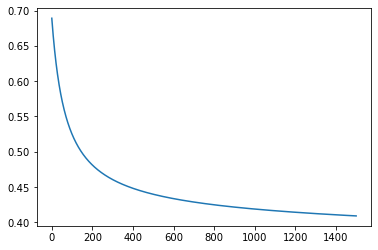

In [250]:
plt.plot(J_storage)

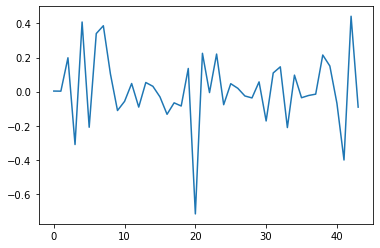

In [251]:
plt.plot(beta)

### Scatter plots for a few of the predictor variables for visual represantation of prediction accuracy

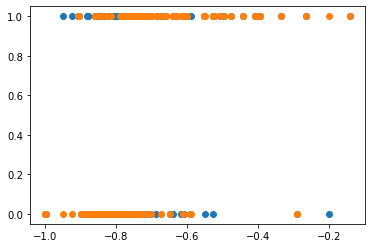

In [252]:
plt.scatter(df_features_test["LEUKOCYTES_MEAN"], df_target_test)
plt.scatter(df_features_test["LEUKOCYTES_MEAN"], pred)

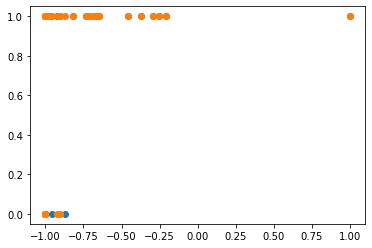

In [253]:
plt.scatter(df_features_test["BE_ARTERIAL_MEAN"], df_target_test)
plt.scatter(df_features_test["BE_ARTERIAL_MEAN"], pred)

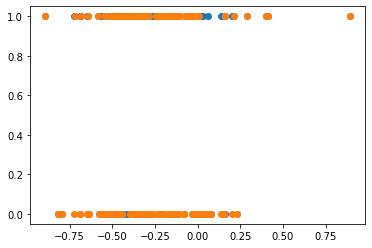

In [254]:
plt.scatter(df_features_test["BLOODPRESSURE_SISTOLIC_MEAN"], df_target_test)
plt.scatter(df_features_test["BLOODPRESSURE_SISTOLIC_MEAN"], pred)

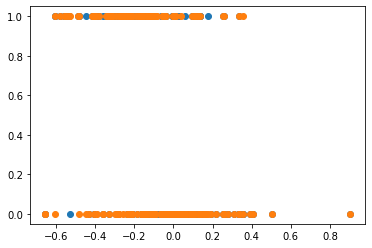

In [255]:
plt.scatter(df_features_test["BLOODPRESSURE_DIASTOLIC_MEAN"], df_target_test)
plt.scatter(df_features_test["BLOODPRESSURE_DIASTOLIC_MEAN"], pred)

#### Confusion matrix and Accuracy of trained model

In [256]:
result = confusion_matrix(df_target_test.values, pred, [1,0])
print(result)

{(1, 1): 54, (1, 0): 32, (0, 1): 15, (0, 0): 73}


In [257]:
ans = calc_accuracy(result)

Accuracy:  0.7298850574712644
Sensitivity:  0.627906976744186
Specificity:  0.8295454545454546
Precision:  0.782608695652174


### Confusion Matrix

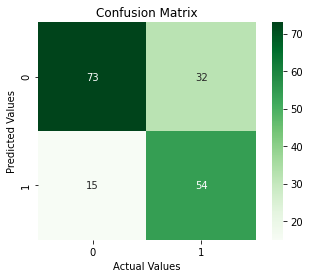

In [258]:
srs = pd.Series(list(result.values()),
index=pd.MultiIndex.from_tuples(result.keys()))
res_df = srs.unstack()
cm = sns.heatmap(res_df.T, cmap='Greens', annot=True, square=True, fmt='d')
cm.set_title("Confusion Matrix")
cm.set(xlabel = "Actual Values", ylabel = "Predicted Values");

### The first iteration of the model has been run and the Accuracy of 0.730 is favourable. 

However, the model currently has 43 predictor variables, and that might result in overfitting. The large number of predictor variables also makes the model extremely complicated. As such, we are going to systematically reduce the number of variables. 


It is known that the beta matrix contains the coefficients for each of the predictor variables. From our research, we have learnt that the magnitude of each beta value determines the significance of each predictor variable respectively. This relationship is not always true, especially if the predictor variables have different scales. However, since all our predictor variables are normalised, we believe that using the beta values to determine the significance of variable is acceptable. 


As such, we are going to obtain the magnitude of the beta values and sort them in ascending order. Then, we will choose 20 of the largest beta values and train the logistic regression model once again.


After iteratively reducing the number of predictor variables without a significant decrease in Accuracy (if any), we have found that using 5 predictor variables gives the best model. 

#### Confusion matrix and Accuracy of trained model

In [ ]:
result = confusion_matrix(df_target_test.values, pred, [1,0])
print(result)

# Obtain coefficients of Betas for filtering predictor variables to be used 

In [273]:
## Removing the beta_0 
beta_removed_0 = beta[1:]
absolute_beta = abs(beta_removed_0)
beta_ls = absolute_beta.tolist()
abs_beta_sorted = sorted(beta_ls)

## Creating a dictionary to map each beta value to the colname
features_colnames = df_features.columns
features_beta_dict = dict(zip(features_colnames, beta_ls))

abs_beta_sorted_5 = abs_beta_sorted[-5:]


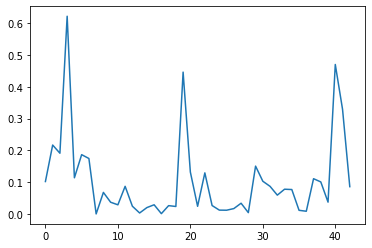

In [274]:
plt.plot(absolute_beta)

#### Getting the new column names corresponding to the largest magnitude of 5 Beta values

In [275]:
new_cols = []
for k, v in features_beta_dict.items():
    if v in abs_beta_sorted_5:
        new_cols.append(k)
        
print(new_cols)

['AGE_PERCENTIL', 'WINDOW', 'LACTATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'BLOODPRESSURE_SISTOLIC_MEAN']


In [276]:
new_cols

['AGE_PERCENTIL',
 'WINDOW',
 'LACTATE_MEAN',
 'BLOODPRESSURE_DIASTOLIC_MEAN',
 'BLOODPRESSURE_SISTOLIC_MEAN']

# Training the model again using new predictor variables

In [277]:
# Extract the features and the target columns
df_features, df_target = get_features_targets(df_final, new_cols, [ls_new2_target])

# Split the data with random_state = 100 and 30% test size
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state=100, test_size=0.3)

# Normalize the features
df_features_train_z = normalize_z(df_features_train)

# Change the feature columns to numpy array and append column of 1s
features = prepare_feature(df_features_train_z)

# Change the target column to numpy array
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01

# Provide initial guess for theta
beta = np.zeros((features.shape[1], 1))

# Call the gradient descent method
beta, J_storage = gradient_descent_logreg(features, target, beta, alpha, iterations)


In [264]:
pred = predict(df_features_test, beta)

In [265]:
result = confusion_matrix(df_target_test.values, pred, [1,0])

print(result)

{(1, 1): 58, (1, 0): 28, (0, 1): 18, (0, 0): 70}


In [266]:
ans = calc_accuracy(result)

Accuracy:  0.735632183908046
Sensitivity:  0.6744186046511628
Specificity:  0.7954545454545454
Precision:  0.7631578947368421


### Confusion Matrix

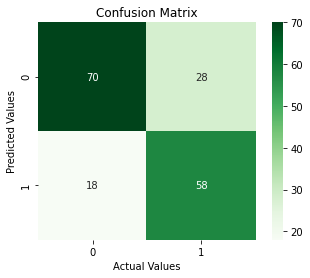

In [267]:
srs = pd.Series(list(result.values()),
index=pd.MultiIndex.from_tuples(result.keys()))
res_df = srs.unstack()
cm = sns.heatmap(res_df.T, cmap='Greens', annot=True, square=True, fmt='d')
cm.set_title("Confusion Matrix")
cm.set(xlabel = "Actual Values", ylabel = "Predicted Values");

### Improving the model even further

The model with only 5 predictor variables performs better with an accuracy of 0.736. However, we believe there is still room for improvement. We now train the model once again with the initial number of predictor variables, but with a different imputation method of filling Nan values with the mean value of each predictor variable. Since each predictor variable is a particular medical condition, filling the missing values with the column mean is appropriate.


After re-training the model, the predictor variables will once again be filtered by obtaining the best 5 predictor variables with the best Beta coefficients and evaluated by the confusion matrix.


To prevent this notebook from being unnecessarily long, we will just re-run the cells above and display the results below.

### Model performance with fillna(mean) and 43 predictor variables


In [271]:
pred = predict(df_features_test, beta)

result = confusion_matrix(df_target_test.values, pred, [1,0])
print(result)

ans = calc_accuracy(result)

{(1, 1): 67, (1, 0): 95, (0, 1): 13, (0, 0): 402}
Accuracy:  0.8128249566724437
Sensitivity:  0.41358024691358025
Specificity:  0.9686746987951808
Precision:  0.8375


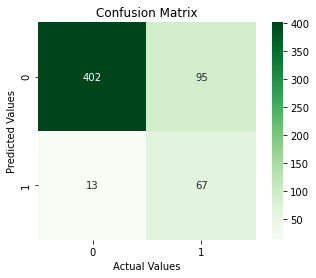

In [272]:
srs = pd.Series(list(result.values()),
index=pd.MultiIndex.from_tuples(result.keys()))
res_df = srs.unstack()
cm = sns.heatmap(res_df.T, cmap='Greens', annot=True, square=True, fmt='d')
cm.set_title("Confusion Matrix")
cm.set(xlabel = "Actual Values", ylabel = "Predicted Values");

### Model performance with fillna(mean) and 5 best predictor variables

In [278]:
pred = predict(df_features_test, beta)

result = confusion_matrix(df_target_test.values, pred, [1,0])
print(result)

ans = calc_accuracy(result)

{(1, 1): 70, (1, 0): 92, (0, 1): 21, (0, 0): 394}
Accuracy:  0.804159445407279
Sensitivity:  0.43209876543209874
Specificity:  0.9493975903614458
Precision:  0.7692307692307693


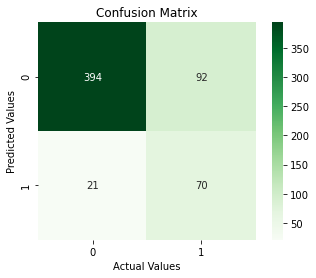

In [279]:
srs = pd.Series(list(result.values()),
index=pd.MultiIndex.from_tuples(result.keys()))
res_df = srs.unstack()
cm = sns.heatmap(res_df.T, cmap='Greens', annot=True, square=True, fmt='d')
cm.set_title("Confusion Matrix")
cm.set(xlabel = "Actual Values", ylabel = "Predicted Values");

## Drawing conclusions from the model's performance

#### The model with Nan values imputed by filling with the column mean (0.804) performs better than the model with Nan values being dropped (0.735). 


As observed, iteratively decreasing the number of predictor variables from the initial 43 to the final 5 has resulted in a slight dip in Accuracy. However, it is undeniable that the model is much simpler due to the much lower number of predictor variables, while still being able to achieve a high overall Accuracy score. The Specificity and Precision values are also satisfactory. The only limitation of this model is the low Sensitivity value. 


We have decided to use the Confusion Matrix and Accuracy as our metric due to their ease of understanding and mathematical simplicity. There are many other metrics that can be used to evaluate Logistic Regression models; some of which are AIC (Akaike Information Criterion) and ROC AUC (Area Under Curve of a Receiver Operating Characteristic Curve). However, these metrics are not as mathematically elegant as the confusion matrix as they are more complicated to implement.


We believe that the simplicity of our chosen evaluation metrics is as important as the effectiveness of it. 

### References

https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

https://towardsdatascience.com/introduction-to-aic-akaike-information-criterion-9c9ba1c96ced

https://www.displayr.com/how-to-interpret-logistic-regression-coefficients/